In [ ]:
# mnist addition using conv nets!!! multiple inputs (2 streams), 
# and multiple outputs (losses to predict each of the digits, plus addition)

In [27]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import time
import os

In [3]:
# transforms
mnist_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])
                                        ])

In [11]:
# load train/validation MNIST datasets
mnist_train_data = datasets.MNIST('/home/jovyan/MNIST/', train=True, download=False, transform=mnist_transforms)
mnist_val_data = datasets.MNIST('/home/jovyan/MNIST/', train=False, download=False, transform=mnist_transforms)

60000
<class 'tuple'>
5


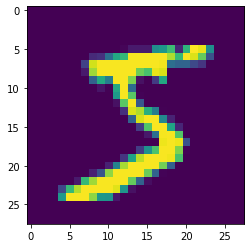

In [26]:
print(len(mnist_train_data))
print(type(mnist_train_data[0]))
img, label = mnist_train_data[0]
print(label)
plt.imshow(img.reshape(28,28))
plt.show()


In [55]:
class Mnist_Custom_Dataset(Dataset):
    """
    Custom MNIST dataset that returns 2 digits (images), their respective labels
    and the summation of the two numbers (labels).
    """
    def __init__(self, images, labels):
        """
        args:
        
        images (torch.tensor): tensor of all the inputs (images) for a dataset
        labels (torch.tensor): tensor of the labels corresponding to inputs
        """
        
        self.images = images
        self.labels = labels
        self.N = len(self.labels)

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        # dataset will return 2 digits and their labels, as well as their summation as the "true" label
        first_image = self.images[idx]
        first_label = self.labels[idx]
        
        # sample a random image for the 2nd digit
        second_idx = torch.randint(0, self.N, (1,)).item()
        second_image = self.images[second_idx]
        second_label = self.labels[second_idx]
        
        summation_label = first_label + second_label
        
        return first_image, first_label, second_image, second_label, summation_label

In [50]:
# separate the inputs from labels
mnist_train_inputs = [mnist_train_data[i][0] for i in range(len(mnist_train_data))]
mnist_train_labels = [torch.tensor(mnist_train_data[i][1]) for i in range(len(mnist_train_data))]

mnist_val_inputs = [mnist_val_data[i][0] for i in range(len(mnist_val_data))]
mnist_val_labels = [torch.tensor(mnist_val_data[i][1]) for i in range(len(mnist_val_data))]

In [51]:
mnist_train_inputs = torch.stack(mnist_train_inputs)
print(mnist_train_inputs.shape)
mnist_train_labels = torch.stack(mnist_train_labels)
print(mnist_train_labels.shape)

mnist_val_inputs = torch.stack(mnist_val_inputs)
print(mnist_val_inputs.shape)
mnist_val_labels = torch.stack(mnist_val_labels)
print(mnist_val_labels.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [56]:
# now build our custom dataset
custom_mnist_train_dataset = Mnist_Custom_Dataset(mnist_train_inputs, mnist_train_labels)
custom_mnist_val_dataset = Mnist_Custom_Dataset(mnist_val_inputs, mnist_val_labels)

In [57]:
# just get data from the dataset
digit_1, label_1, digit_2, label_2, summation_label = custom_mnist_train_dataset.__getitem__(0)
print(label_1, label_2, summation_label)

tensor(5) tensor(6) tensor(11)


In [58]:
# define some hypers
BATCH_SIZE = 32
LEARNING_RATE = 0.01
NUM_EPOCHS = 5
MODEL_WEIGHT_SAVE_PATH = '/home/jovyan/best-mnist-summation-val-weights.pth'

In [59]:
# data loader
train_dataloader = torch.utils.data.DataLoader(custom_mnist_train_dataset,
                                              batch_size = BATCH_SIZE,
                                              shuffle = True
                                              )

val_dataloader = torch.utils.data.DataLoader(custom_mnist_val_dataset,
                                              batch_size = BATCH_SIZE,
                                              shuffle = False
                                              )

In [125]:
# define a neural network
class SummationNet(nn.Module):
    def __init__(self):
        super(SummationNet, self).__init__()
        
        # NOTE: input shape is (1, 28, 28) 
        
        # should we use 2 separate input branches or use "parameter" sharing
        # via a single input branch?
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2)
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.pooling = nn.AvgPool2d(kernel_size = 3, stride=3)
        # representation will now be of shape (batch_size, 32, 3, 3)

        # sequential
        self.input_branch_2 = nn.Sequential(
                                          nn.Conv2d(1, 16, 3, stride=2),
                                          nn.ReLU(),
                                          nn.Conv2d(16, 16, 3),
                                          nn.ReLU(),
                                          nn.Conv2d(16, 32, 3),
                                          nn.ReLU(),
                                          nn.AvgPool2d(kernel_size = 3, stride=3)
                                        )
        
        # auxiliary output layers
        self.aux_lin_1= nn.Linear(32*3*3, 128)
        self.aux_fc_1 = nn.Linear(128, 10)
        self.aux_lin_2 = nn.Linear(32*3*3, 128)
        self.aux_fc_2 = nn.Linear(128, 10)
        
        # summation label head
        self.linear1 = nn.Linear(128*2, 128)
        self.fc = nn.Linear(128, 19)
        
    def forward(self, x1, x2):
        
        # first input branch
        x1 = F.relu(self.conv1(x1))
        x1 = F.relu(self.conv2(x1))
        x1 = F.relu(self.conv3(x1))
        x1 = self.pooling(x1)
        
        # second input branch
        x2 = self.input_branch_2(x2)
        
        # auxiliary outputs
        x1 = x1.view(x1.shape[0], -1)
        x1 = F.relu(self.aux_lin_1(x1))
        x1_aux_output = self.aux_fc_1(x1)
        
        x2 = x2.view(x2.shape[0], -1)
        x2 = F.relu(self.aux_lin_2(x2))
        x2_aux_output = self.aux_fc_2(x2)
        
        # summation head
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.linear1(x))
        x = self.fc(x)
        
        return x1_aux_output, x2_aux_output, x

In [126]:
# build model
net = SummationNet()

print("Model structure: ", net)

params = filter(lambda p: p.requires_grad, net.parameters())
num_params = sum([np.prod(p.size()) for p in params])
print("Model parameters: ", num_params)



Model structure:  SummationNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pooling): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (input_branch_2): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=3, stride=3, padding=0)
  )
  (aux_lin_1): Linear(in_features=288, out_features=128, bias=True)
  (aux_fc_1): Linear(in_features=128, out_features=10, bias=True)
  (aux_lin_2): Linear(in_features=288, out_features=128, bias=True)
  (aux_fc_2): Linear(in_features=128, out_features=10, bias=True)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=19, bias=True)
)
Model parameters

In [127]:
# build optimizer
optimizer = optim.SGD(net.parameters(), 
                      lr=LEARNING_RATE, 
                      momentum=0.9)

In [128]:
# build loss function
cross_entropy_loss = nn.CrossEntropyLoss()

In [129]:
# keeping track of metrics

best_val_acc = 0.0
training_losses = []
training_accs = []
val_losses = []
val_accs = []

training_aux1_accs = []
training_aux2_accs = []
val_aux1_accs = []
val_aux2_accs = []



In [130]:
# define a training epoch
def do_training_epoch(model, dataloader, loss_func, optimizer, alpha=0.2):
    
    # init some metrics
    num_instances = 0
    num_correct = 0
    running_loss = 0.0
    
    aux1_num_correct = 0
    aux2_num_correct = 0
    
    
    # set the model to be in "train" model
    model.train()
    
    # iterate through the dataloader, batch by batch
    
    for i, batch in enumerate(dataloader):
        
        digit1, label1, digit2, label2, summation_labels = batch
        
        # pass to GPU?
        
        
        # zero the gradients
        optimizer.zero_grad()
        
        # make sure we are tracking gradients from here on out
        with torch.set_grad_enabled(True):
            
            # pass data through the network
            aux1, aux2, output = model(digit1, digit2)
            
            # compute the losses
            aux1_loss = loss_func(aux1, label1)
            aux2_loss = loss_func(aux2, label2)
            summation_loss = loss_func(output, summation_labels)
            
            loss = summation_loss + alpha*aux1_loss + alpha*aux2_loss
            
            # call back-prop
            loss.backward()
            
            # do a step of gradient descent
            optimizer.step()
        
        
        # now let's update our metrics
        with torch.no_grad():
            _, summation_preds = torch.max(output, 1)
            running_loss += loss.item() * x.size(0)
            
            # summation acc metrics
            num_correct += torch.sum(summation_preds == summation_labels.data)
            num_instances += x.size(0)
            
            # aux heads
            _, aux1_preds = torch.max(aux1, 1)
            aux1_num_correct += torch.sum(aux1_preds == label1.data)
            
            _, aux2_preds = torch.max(aux2, 1)
            aux2_num_correct += torch.sum(aux2_preds == label2.data)
            
            
            
    mean_loss = running_loss / num_instances
    mean_accuracy = num_correct / num_instances
    
    mean_aux1_acc = aux1_num_correct / num_instances
    mean_aux2_acc = aux2_num_correct / num_instances
    return mean_accuracy, mean_loss, mean_aux1_acc, mean_aux2_acc

In [131]:
# define a validation epoch
def do_validation_epoch(model, dataloader, loss_func, alpha=0.2):
    # init some metrics
    num_instances = 0
    num_correct = 0
    running_loss = 0.0
    
    aux1_num_correct = 0
    aux2_num_correct = 0
    
    
    # set the model to be in "evaluation" model
    model.eval()
    
    # iterate through the dataloader, batch by batch
    
    for i, batch in enumerate(dataloader):
        
        digit1, label1, digit2, label2, summation_labels = batch
        
        # pass to GPU?
        

        # make sure we are tracking gradients from here on out
        with torch.no_grad():
            # pass data through the network
            aux1, aux2, output = model(digit1, digit2)
            
            # compute the losses
            aux1_loss = loss_func(aux1, label1)
            aux2_loss = loss_func(aux2, label2)
            summation_loss = loss_func(output, summation_labels)
            
            loss = summation_loss + alpha*aux1_loss + alpha*aux2_loss

            # now let's update our metrics
            _, summation_preds = torch.max(output, 1)
            running_loss += loss.item() * x.size(0)
            
            # summation acc metrics
            num_correct += torch.sum(summation_preds == summation_labels.data)
            num_instances += x.size(0)
            
            # aux heads
            _, aux1_preds = torch.max(aux1, 1)
            aux1_num_correct += torch.sum(aux1_preds == label1.data)
            
            _, aux2_preds = torch.max(aux2, 1)
            aux2_num_correct += torch.sum(aux2_preds == label2.data)
            
            
    mean_loss = running_loss / num_instances
    mean_accuracy = num_correct / num_instances
    
    mean_aux1_acc = aux1_num_correct / num_instances
    mean_aux2_acc = aux2_num_correct / num_instances
    
    return mean_accuracy, mean_loss, mean_aux1_acc, mean_aux2_acc

In [132]:
# train model, 
for epoch in range(NUM_EPOCHS):
    print("Let's do it up, epoch number: ", (epoch+1), " of: ", NUM_EPOCHS)
    
    # train epoch
    packed_ = do_training_epoch(net, train_dataloader, cross_entropy_loss, optimizer)
    epoch_acc, epoch_loss, epoch_aux1_acc, epoch_aux2_acc = packed_
    
    print("Training loss: ", epoch_loss)
    print("Summation accuracy: ", epoch_acc.item())
    print("Aux1 and aux2 head accs: ", epoch_aux1_acc, epoch_aux2_acc)
    
    # update metrics
    training_losses.append(epoch_loss)
    training_accs.append(epoch_acc.item())
    training_aux1_accs.append(epoch_aux1_acc.item())
    training_aux2_accs.append(epoch_aux2_acc.item())
    
    
    # val epoch
    packed_ = do_validation_epoch(net, val_dataloader, cross_entropy_loss)
    epoch_acc, epoch_loss, epoch_aux1_acc, epoch_aux2_acc = packed_
    
    print("Summation accuracy: ", epoch_acc.item())
    print("Validation loss: ", epoch_loss)
    print("Aux1 and aux2 head accs: ", epoch_aux1_acc, epoch_aux2_acc)
    
    
    # update metrics
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc.item())
    
    val_aux1_accs.append(epoch_aux1_acc.item())
    val_aux2_accs.append(epoch_aux2_acc.item())
    
    # is this the best epoch yet? if so, let's save the model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        state_dict = {'weights': net.state_dict(),
                     'epoch': epoch,
                      'val_acc': epoch_acc.item()
                     }
        torch.save(state_dict, MODEL_WEIGHT_SAVE_PATH)

Let's do it up, epoch number:  1  of:  5
Training loss:  1.793623802514871
Summation accuracy:  0.5181000232696533
Aux1 and aux2 head accs:  tensor(0.7145) tensor(0.7376)
Summation accuracy:  0.905351459980011
Validation loss:  0.35628105366763213
Aux1 and aux2 head accs:  tensor(0.9643) tensor(0.9651)
Let's do it up, epoch number:  2  of:  5
Training loss:  0.294645399432381
Summation accuracy:  0.9257000088691711
Aux1 and aux2 head accs:  tensor(0.9708) tensor(0.9724)
Summation accuracy:  0.947484016418457
Validation loss:  0.1913309787331631
Aux1 and aux2 head accs:  tensor(0.9785) tensor(0.9796)
Let's do it up, epoch number:  3  of:  5
Training loss:  0.19047009393100936
Summation accuracy:  0.9510666728019714
Aux1 and aux2 head accs:  tensor(0.9811) tensor(0.9817)
Summation accuracy:  0.9629592895507812
Validation loss:  0.1386033417694211
Aux1 and aux2 head accs:  tensor(0.9832) tensor(0.9834)
Let's do it up, epoch number:  4  of:  5
Training loss:  0.1424937642611563
Summation a

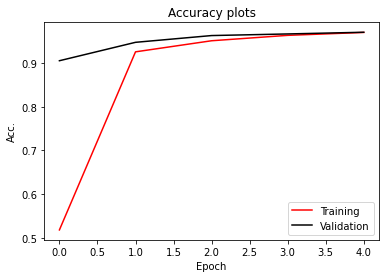

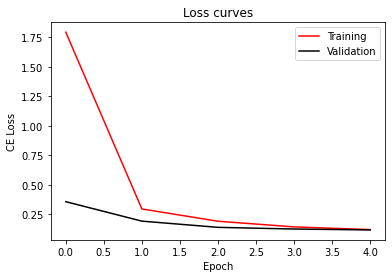

In [133]:
# evaluation plots

plt.plot(training_accs, color='r', label='Training')
plt.plot(val_accs, color='k', label="Validation")
plt.title("Accuracy plots")
plt.ylabel("Acc.")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.close()

plt.plot(training_losses, color='r', label='Training')
plt.plot(val_losses, color='k', label="Validation")
plt.title("Loss curves")
plt.ylabel("CE Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.close()